# RSI 

### 賴志宏 Chih-Hung Lai

Created: 2021.12.23  Last modified:2021.12.23

## 備註：
- 本講義為自行計算RSI的值，若要呼叫現有的套件，可使用TA-Lib
- [TA-Lib 教學](https://medium.com/ai%E8%82%A1%E4%BB%94/%E7%94%A8-python-%E5%BF%AB%E9%80%9F%E8%A8%88%E7%AE%97-158-%E7%A8%AE%E6%8A%80%E8%A1%93%E6%8C%87%E6%A8%99-26f9579b8f3a) 

## Table of Contents
1. 介紹RSI指標
2. 讀入股票資料  
3. 計算RSI線
4. 繪出RSI線與股價圖  
5. 策略1：超買超賣區
    1. 策略介紹  
    2. 策略買賣信號
    3. 繪製交易點
    4. 回溯檢驗
6. 策略2：
    1. 策略介紹  
    2. 策略買賣信號
    3. 繪製交易點
    4. 回溯檢驗
7. 策略3：
    1. 策略介紹  
    2. 策略買賣信號
    3. 繪製交易點
    4. 回溯檢驗
額外參考資料

# 1. 介紹RSI指標
![](images/rsi.png)

## 2. 讀入股票資料

In [11]:
file = "0050.csv"


In [12]:
import pandas as pd
import numpy as np


ticker = pd.read_csv(file)

# change the name of columns
ticker.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

# set the column "Date" to index
ticker = ticker.set_index('Date')

# set index column("Date") from string to datetime.datetime
ticker.index = pd.to_datetime(ticker.index)

# sort index column("Date") chronologically
ticker = ticker.sort_index()

# take latest 300 price data for analysis
ticker = ticker.tail(300)
print(ticker)

              Open    High     Low   Close  Volume
Date                                              
2019-12-27   97.60   98.15   97.60   98.00    2978
2019-12-30   98.00   98.25   97.60   97.80    3138
2019-12-31   97.10   97.20   96.95   96.95    4303
2020-01-02   97.05   98.00   97.05   97.65    4882
2020-01-03   98.30   98.70   97.00   97.65    6813
...            ...     ...     ...     ...     ...
2021-03-22  132.40  133.60  131.60  133.40    5510
2021-03-23  133.90  134.70  133.60  133.60    6994
2021-03-24  131.80  132.45  131.30  131.50   11082
2021-03-25  131.10  132.55  130.60  131.95    5186
2021-03-26  133.05  134.40  132.55  134.35    8134

[300 rows x 5 columns]


## 3. 計算RSI線

In [13]:
# Define constants
RSI_n = 6
upperBound = 90
lowerBound = 10
middle_line = 50

# Create a empty dataFrame with original index
# To store some temporary data
tmp = pd.DataFrame(index=ticker.index)

# Copy a dataFrame to store result
# deep=True means make a copy instead of link
data = ticker.copy(deep=True)

# tmp['rise'] = ticker['Close'] - ticker['Open']

tmp['rise'] = np.nan
rsi = []
for i in range(1, len(ticker['Close'])):
    rsi.append(round(ticker['Close'][i] - ticker['Close'][i - 1], 2))
tmp['rise'][1:] = rsi.copy()

tmp['rise_only'] = tmp['rise']
tmp['drop_only'] = tmp['rise']

tmp['rise_only'].loc[tmp['rise'] < 0] = 0
tmp['drop_only'].loc[tmp['rise'] > 0] = 0
print(tmp.head(10))

tmp['rise_avg'] = tmp['rise_only'].rolling(RSI_n, min_periods=1).mean()
tmp['drop_avg'] = tmp['drop_only'].rolling(RSI_n, min_periods=1).mean().abs()
print(tmp.head(10))

data['RSI'] = tmp['rise_avg'] / (tmp['rise_avg'] + tmp['drop_avg']) * 100
print(data.head(10))

            rise  rise_only  drop_only
Date                                  
2019-12-27   NaN        NaN        NaN
2019-12-30 -0.20       0.00      -0.20
2019-12-31 -0.85       0.00      -0.85
2020-01-02  0.70       0.70       0.00
2020-01-03  0.00       0.00       0.00
2020-01-06 -1.25       0.00      -1.25
2020-01-07 -0.30       0.00      -0.30
2020-01-08 -0.45       0.00      -0.45
2020-01-09  1.30       1.30       0.00
2020-01-10  0.35       0.35       0.00
            rise  rise_only  drop_only  rise_avg  drop_avg
Date                                                      
2019-12-27   NaN        NaN        NaN       NaN       NaN
2019-12-30 -0.20       0.00      -0.20  0.000000  0.200000
2019-12-31 -0.85       0.00      -0.85  0.000000  0.525000
2020-01-02  0.70       0.70       0.00  0.233333  0.350000
2020-01-03  0.00       0.00       0.00  0.175000  0.262500
2020-01-06 -1.25       0.00      -1.25  0.140000  0.460000
2020-01-07 -0.30       0.00      -0.30  0.116667  0.433333
2

## 4. 繪出RSI線與股價圖 

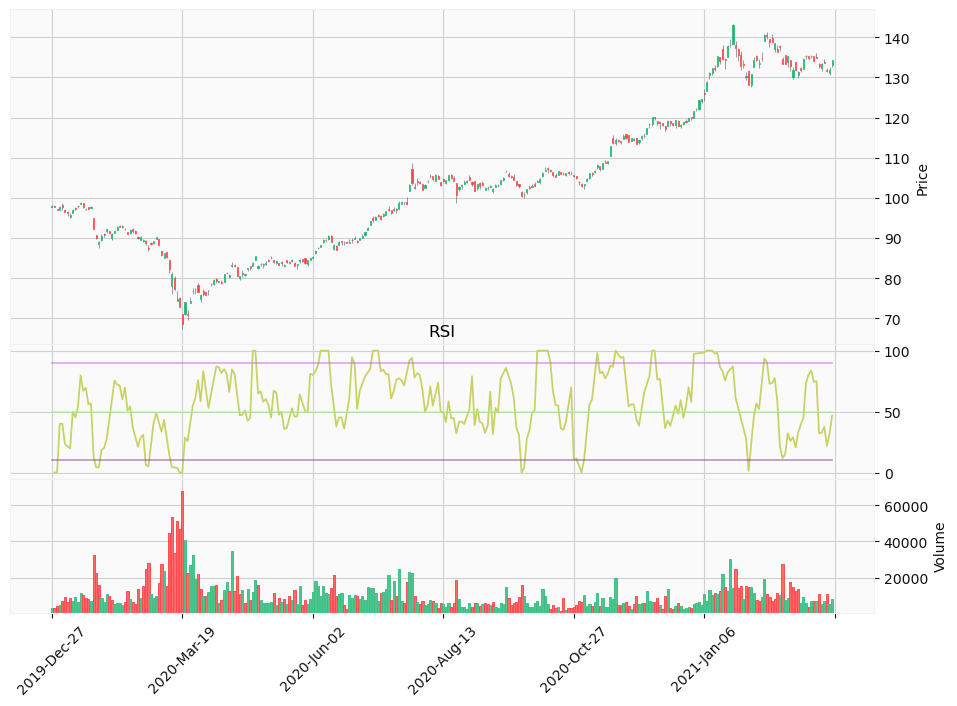

In [14]:
import mplfinance as mpf


plots = [ 
    # Add the RSI indicator to plot
    mpf.make_addplot(data['RSI'], panel = 1, color='#c8d164', title='RSI'),
    
    
    # Add upperbound & lowerbound to plot
    mpf.make_addplot(np.full((len(data)), upperBound), panel = 1, color='#bf5ce0', alpha=0.5),
    mpf.make_addplot(np.full((len(data)), lowerBound), panel = 1, color='#7e3696', alpha=0.5),
    mpf.make_addplot(np.full((len(data)), middle_line), panel = 1, color='#8eff75', alpha=0.5),
]

# make the graph(plot)
mpf.plot( data, 
            type='candle',       # candlestick chart of stock price
            volume=True,         # plots trading volume as well
            volume_panel=2,
            figscale=1.5,          # make graph twice bigger
            style='yahoo',       # color scheme using 'yahoo' style
            addplot = plots,
)      

## 5. 策略1：超買超賣區

### 5.1 超買超賣區：策略介紹
80以上是超買區，90以上是嚴重超買區，出現M頭應該賣  
20以下是超賣區，10以上是嚴重超賣區，出現W頭應該買  

因爲M頭和W頭的判斷比較難，  
所以這裏簡化成95以上就賣  
15以下就買。  

買入：RSI 15以下  
賣出：RSI 95以上

### 5.2 超買超賣區：策略買賣信號

In [15]:
# initialize 'buy' & 'sell' column by filling with 0
strategy_1 = pd.DataFrame(index=ticker.index)
strategy_1['buy'] = np.zeros(ticker.shape[0])
strategy_1['sell'] = np.zeros(ticker.shape[0])

strategy_1_upperbound = 95
strategy_1_lowerbound = 15

# skip first RSI_n days
for i in range(RSI_n, data.shape[0]):

    if(data['RSI'][i] < strategy_1_lowerbound):
        

        strategy_1.loc[(data.index[i], 'buy')] = 1
        print('buy  |', data.index[i], data['Close'][i])
    if(data['RSI'][i] > strategy_1_upperbound):

        strategy_1.loc[(data.index[i], 'sell')] = 1
        print('sell |', data.index[i], data['Close'][i])

buy  | 2020-01-30 00:00:00 92.15
buy  | 2020-01-31 00:00:00 89.95
buy  | 2020-02-03 00:00:00 89.05
buy  | 2020-02-27 00:00:00 88.65
buy  | 2020-03-02 00:00:00 87.35
buy  | 2020-03-12 00:00:00 82.15
buy  | 2020-03-13 00:00:00 81.0
buy  | 2020-03-16 00:00:00 77.3
buy  | 2020-03-17 00:00:00 74.85
buy  | 2020-03-18 00:00:00 72.8
buy  | 2020-03-19 00:00:00 68.55
sell | 2020-04-29 00:00:00 83.7
sell | 2020-04-30 00:00:00 85.5
sell | 2020-06-05 00:00:00 88.35
sell | 2020-06-08 00:00:00 89.5
sell | 2020-06-09 00:00:00 89.6
sell | 2020-06-10 00:00:00 90.45
sell | 2020-07-07 00:00:00 94.5
sell | 2020-07-08 00:00:00 95.15
sell | 2020-07-09 00:00:00 95.45
buy  | 2020-09-24 00:00:00 100.45
buy  | 2020-09-25 00:00:00 100.65
sell | 2020-10-06 00:00:00 104.25
sell | 2020-10-07 00:00:00 104.8
sell | 2020-10-08 00:00:00 106.2
sell | 2020-10-12 00:00:00 107.05
sell | 2020-10-13 00:00:00 107.1
buy  | 2020-10-27 00:00:00 105.5
buy  | 2020-10-28 00:00:00 105.0
buy  | 2020-10-29 00:00:00 103.85
buy  | 2020-1

### 5.3 超買超賣區：繪製交易點

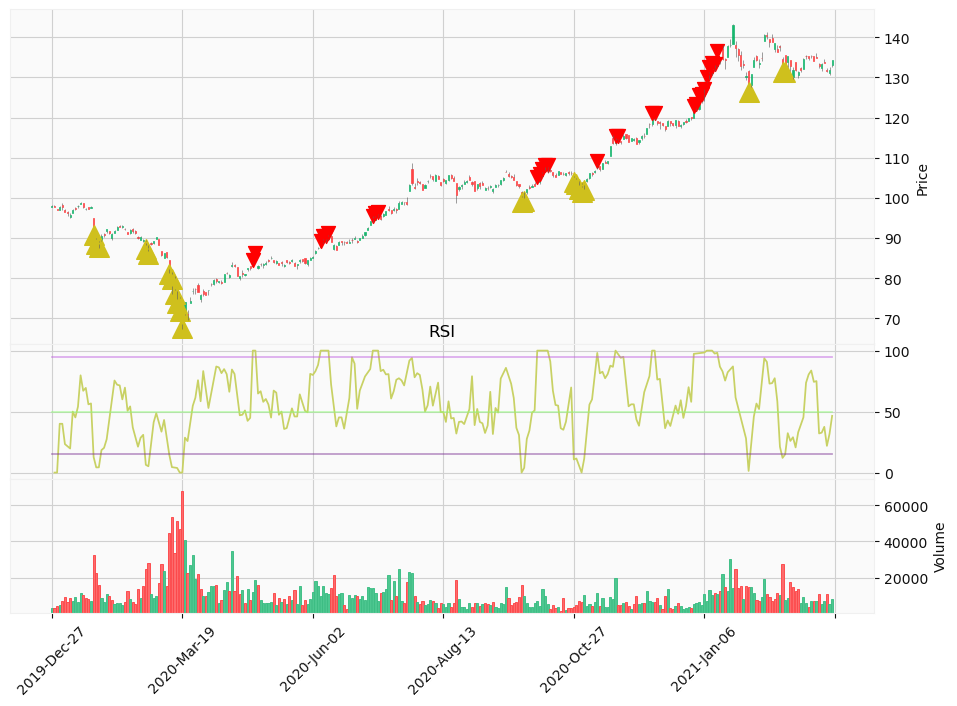

In [16]:
plots = []

# the position in graph
buy, sell = [], []

# Adjust the position to avoid signals block the lines
for index, row in data.iterrows():
    buy.append(row['Close']*0.985 if strategy_1.loc[index]['buy'] else np.nan)
    sell.append(row['Close']*1.01 if strategy_1.loc[index]['sell'] else np.nan)


plots = [ 
    # Add the RSI indicator to plot
    mpf.make_addplot(data['RSI'], panel = 1, color='#c8d164', title='RSI'),
    
    
    # Add upperbound & lowerbound to plot
    mpf.make_addplot(np.full((len(data)), strategy_1_upperbound), panel = 1, color='#bf5ce0', alpha=0.5),
    mpf.make_addplot(np.full((len(data)), strategy_1_lowerbound), panel = 1, color='#7e3696', alpha=0.5),
    mpf.make_addplot(np.full((len(data)), middle_line), panel = 1, color='#8eff75', alpha=0.5),
]

# Add trading point to plot
#    np.isnan(sell) determine the value is nan or not
#    count_nonzero(np.isnan(sell)) counts how many nan we have
#    if nan amount equal the length of array, we don't have sell record
if not np.count_nonzero(np.isnan(sell)) == len(sell):
    plots.append(mpf.make_addplot(sell , type = 'scatter', color = 'red', marker = 'v', markersize = 100))
if not np.count_nonzero(np.isnan(buy)) == len(buy):
    plots.append(mpf.make_addplot(buy , type = 'scatter', color = '#cfc01d', marker = '^', markersize = 200))

mpf.plot( data, 
            type='candle',       # candlestick chart of stock price
            volume=True,         # plots trading volume as well
            volume_panel=2,
            figscale=1.5,          # make graph twice bigger
            style='yahoo',       # color scheme using 'yahoo' style
            addplot = plots,
)    

### 5.4 超買超賣區：回溯檢驗

In [17]:
# how many shares we hold, and the money balance
have_shares , balance = 0, 0

# multiple buy and 1 sell as "a trade"
# record trading times and how many trade are making money
make_money, trade_times = 0, 0

# we use geometic average
# this is products of return rate
return_rate = 1
for index, row in data.iterrows():
    
    if(strategy_1.loc[index]['buy'] == 1):
        balance -= row['Close']
        have_shares += 1
        print('buy  | {} | {:>6.2f}'.format( index, row['Close']))
    
    # sell signal or it reach ends
    elif((strategy_1.loc[index]['sell'] == 1 or index == data.index.values[-1])and
    # and we have some shares
          have_shares != 0):
        
        print('sell | {} | {:>6.2f} * {}'.format(index, row['Close'], have_shares))
        
        principal = -balance
        balance += row['Close'] * have_shares
        
        # to calculate accuracy
        trade_times += 1
        if(balance > 0):
            make_money += 1
            
        # plus 1 avoiding get too small
        return_rate *= 1+(balance / principal)
        
        # reset balance & shares
        balance = 0
        have_shares = 0
      

print()
print('cumulative return rate :', (return_rate-1) * 100, '%')
if(trade_times != 0):
    print('accuracy :', make_money/ trade_times * 100, '%')

buy  | 2020-01-30 00:00:00 |  92.15
buy  | 2020-01-31 00:00:00 |  89.95
buy  | 2020-02-03 00:00:00 |  89.05
buy  | 2020-02-27 00:00:00 |  88.65
buy  | 2020-03-02 00:00:00 |  87.35
buy  | 2020-03-12 00:00:00 |  82.15
buy  | 2020-03-13 00:00:00 |  81.00
buy  | 2020-03-16 00:00:00 |  77.30
buy  | 2020-03-17 00:00:00 |  74.85
buy  | 2020-03-18 00:00:00 |  72.80
buy  | 2020-03-19 00:00:00 |  68.55
sell | 2020-04-29 00:00:00 |  83.70 * 11
buy  | 2020-09-24 00:00:00 | 100.45
buy  | 2020-09-25 00:00:00 | 100.65
sell | 2020-10-06 00:00:00 | 104.25 * 2
buy  | 2020-10-27 00:00:00 | 105.50
buy  | 2020-10-28 00:00:00 | 105.00
buy  | 2020-10-29 00:00:00 | 103.85
buy  | 2020-10-30 00:00:00 | 103.00
buy  | 2020-11-02 00:00:00 | 103.40
sell | 2020-11-09 00:00:00 | 108.10 * 5
buy  | 2021-01-29 00:00:00 | 128.20
buy  | 2021-02-26 00:00:00 | 133.40
buy  | 2021-03-02 00:00:00 | 133.45
sell | 2021-03-26 00:00:00 | 134.35 * 3

cumulative return rate : 11.844098650809375 %
accuracy : 100.0 %


## 6. 策略2：中線

RSI在50以上或50以下停留許久可交易

買入：RSI在50以上停留6日可買入  
賣出：RSI在50以下停留6日可賣出

當RSI停留超過6日時
會一直連續交易，爲了避免重復交易
加入冷卻時間

### 6.2 中線：策略買賣信號

In [18]:
# initialize 'buy' & 'sell' column by filling with 0
strategy_2 = pd.DataFrame(index=ticker.index)
strategy_2['buy'] = np.zeros(ticker.shape[0])
strategy_2['sell'] = np.zeros(ticker.shape[0])


trading_interval = 6
trading_cooldown = trading_interval
stagnant_upper, stagnant_lower = 0, 0


# skip first RSI_n days
for i in range(RSI_n, data.shape[0]):
    
    trading_cooldown += 1
    # 在 upperbound 以上的話， counter就加一
    # 否則counter歸零
    if(data['RSI'][i] >= middle_line):
        stagnant_upper += 1
    else:
        stagnant_upper = 0

    # 在 lowerbound 以下的話， counter就加一
    # 否則counter歸零
    if(data['RSI'][i] <= middle_line ):
        stagnant_lower += 1
    else:
        stagnant_lower = 0
     
    if(stagnant_upper > trading_interval and trading_cooldown > trading_interval):
        trading_cooldown = 0
        strategy_2.loc[(data.index[i], 'buy')] = 1
        print('buy  |', data.index[i], data['Close'][i])
        
    if(stagnant_lower > trading_interval and trading_cooldown > trading_interval):
        trading_cooldown = 0
        strategy_2.loc[(data.index[i], 'sell')] = 1
        print('sell |', data.index[i], data['Close'][i])
    
    

sell | 2020-02-07 00:00:00 91.2
buy  | 2020-02-18 00:00:00 91.05
sell | 2020-03-02 00:00:00 87.35
sell | 2020-03-11 00:00:00 85.3
sell | 2020-03-20 00:00:00 74.0
buy  | 2020-04-06 00:00:00 77.05
buy  | 2020-04-15 00:00:00 81.2
buy  | 2020-05-08 00:00:00 84.35
buy  | 2020-06-09 00:00:00 89.6
buy  | 2020-07-02 00:00:00 91.5
buy  | 2020-07-13 00:00:00 96.05
buy  | 2020-07-22 00:00:00 98.95
buy  | 2020-07-31 00:00:00 103.8
buy  | 2020-08-11 00:00:00 104.8
sell | 2020-08-26 00:00:00 104.3
sell | 2020-09-30 00:00:00 103.0
buy  | 2020-10-14 00:00:00 106.7
buy  | 2020-11-12 00:00:00 108.8
buy  | 2020-11-23 00:00:00 115.45
buy  | 2020-12-10 00:00:00 118.6
buy  | 2021-01-05 00:00:00 124.6
buy  | 2021-01-14 00:00:00 134.05
buy  | 2021-01-25 00:00:00 135.6
buy  | 2021-02-22 00:00:00 138.8
sell | 2021-03-08 00:00:00 131.85


### 6.3 中線：繪製交易點

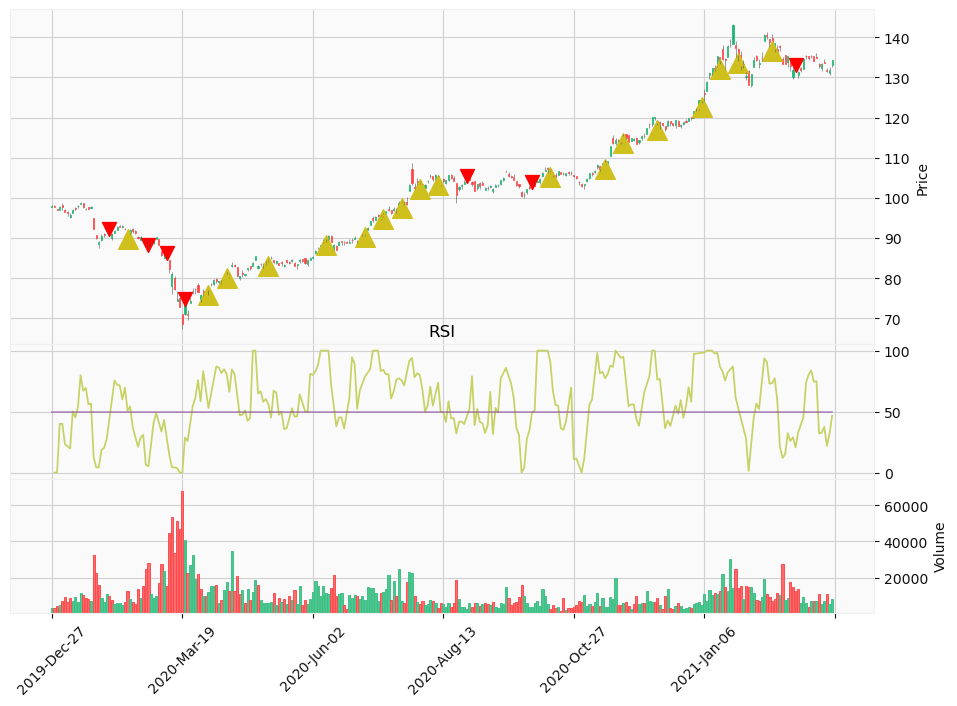

In [19]:
plots = []

# the position in graph
buy, sell = [], []

# Adjust the position to avoid signals block the lines
for index, row in data.iterrows():
    buy.append(row['Close']*0.985 if strategy_2.loc[index]['buy'] else np.nan)
    sell.append(row['Close']*1.01 if strategy_2.loc[index]['sell'] else np.nan)


plots = [ 
    # Add the RSI indicator to plot
    mpf.make_addplot(data['RSI'], panel = 1, color='#c8d164', title='RSI'),
    
    
    # Add middle_line to plot
    mpf.make_addplot(np.full((len(data)), middle_line), panel = 1, color='#7e3696', alpha=0.5),
]

# Add trading point to plot
#    np.isnan(sell) determine the value is nan or not
#    count_nonzero(np.isnan(sell)) counts how many nan we have
#    if nan amount equal the length of array, we don't have sell record
if not np.count_nonzero(np.isnan(sell)) == len(sell):
    plots.append(mpf.make_addplot(sell , type = 'scatter', color = 'red', marker = 'v', markersize = 100))
if not np.count_nonzero(np.isnan(buy)) == len(buy):
    plots.append(mpf.make_addplot(buy , type = 'scatter', color = '#cfc01d', marker = '^', markersize = 200))

mpf.plot( data, 
            type='candle',       # candlestick chart of stock price
            volume=True,         # plots trading volume as well
            volume_panel=2,
            figscale=1.5,          # make graph twice bigger
            style='yahoo',       # color scheme using 'yahoo' style
            addplot = plots,
)    

### 6.4 中線：回溯檢驗

In [20]:
# how many shares we hold, and the money balance
have_shares , balance = 0, 0

# multiple buy and 1 sell as "a trade"
# record trading times and how many trade are making money
make_money, trade_times = 0, 0

# we use geometic average
# this is products of return rate
return_rate = 1
for index, row in data.iterrows():
    
    if(strategy_2.loc[index]['buy'] == 1):
        balance -= row['Close']
        have_shares += 1
        print('buy  | {} | {:>6.2f}'.format( index, row['Close']))
    
    # sell signal or it reach ends
    elif((strategy_2.loc[index]['sell'] == 1 or index == data.index.values[-1])and
    # and we have some shares
          have_shares != 0):
        
        print('sell | {} | {:>6.2f} * {}'.format(index, row['Close'], have_shares))
        
        principal = -balance
        balance += row['Close'] * have_shares
        
        # to calculate accuracy
        trade_times += 1
        if(balance > 0):
            make_money += 1
            
        # plus 1 avoiding get too small
        return_rate *= 1+(balance / principal)
        
        # reset balance & shares
        balance = 0
        have_shares = 0
      

print()
print('cumulative return rate :', (return_rate-1) * 100, '%')
if(trade_times != 0):
    print('accuracy :', make_money/ trade_times * 100, '%')

buy  | 2020-02-18 00:00:00 |  91.05
sell | 2020-03-02 00:00:00 |  87.35 * 1
buy  | 2020-04-06 00:00:00 |  77.05
buy  | 2020-04-15 00:00:00 |  81.20
buy  | 2020-05-08 00:00:00 |  84.35
buy  | 2020-06-09 00:00:00 |  89.60
buy  | 2020-07-02 00:00:00 |  91.50
buy  | 2020-07-13 00:00:00 |  96.05
buy  | 2020-07-22 00:00:00 |  98.95
buy  | 2020-07-31 00:00:00 | 103.80
buy  | 2020-08-11 00:00:00 | 104.80
sell | 2020-08-26 00:00:00 | 104.30 * 9
buy  | 2020-10-14 00:00:00 | 106.70
buy  | 2020-11-12 00:00:00 | 108.80
buy  | 2020-11-23 00:00:00 | 115.45
buy  | 2020-12-10 00:00:00 | 118.60
buy  | 2021-01-05 00:00:00 | 124.60
buy  | 2021-01-14 00:00:00 | 134.05
buy  | 2021-01-25 00:00:00 | 135.60
buy  | 2021-02-22 00:00:00 | 138.80
sell | 2021-03-08 00:00:00 | 131.85 * 8

cumulative return rate : 16.85306656996779 %
accuracy : 66.66666666666666 %


## 7. 策略3：中線+MA

RSI在50以上或50以下停留許久可交易，  
但是會有過多重復交易的問題，  
所以利用金叉+停留做交易點  

買入：RSI在50以上停留6日 + 7日MA穿出30MA   
賣出：RSI在50以下停留6日 + 7日MA跌破30MA

### 7.2 中線+MA：策略買賣信號

In [21]:
# initialize 'buy' & 'sell' column by filling with 0
strategy_3 = pd.DataFrame(index=ticker.index)
strategy_3['buy'] = np.zeros(ticker.shape[0])
strategy_3['sell'] = np.zeros(ticker.shape[0])

MOVING_WINDOW_SHORT = 7
MOVING_WINDOW_LONG = 30
strategy_3['ma_short'] = data['Close'].rolling(MOVING_WINDOW_SHORT).mean()
strategy_3['ma_long'] = data['Close'].rolling(MOVING_WINDOW_LONG).mean()

trading_interval = 6
stagnant_upper, stagnant_lower = 0, 0


# skip first RSI_n days
for i in range(RSI_n, data.shape[0]):
    
    # 在 upperbound 以上的話， counter就加一
    # 否則counter歸零
    if(data['RSI'][i] >= middle_line):
        stagnant_upper += 1
    else:
        stagnant_upper = 0

    # 在 lowerbound 以下的話， counter就加一
    # 否則counter歸零
    if(data['RSI'][i] <= middle_line ):
        stagnant_lower += 1
    else:
        stagnant_lower = 0
     
    if(stagnant_upper > trading_interval):

        # Close price crossover the MA indicator upward
        if (((strategy_3.iloc[i]['ma_short']   > strategy_3.iloc[i]['ma_long'])    and
             (strategy_3.iloc[i-1]['ma_short'] < strategy_3.iloc[i-1]['ma_long'])) and
             (strategy_3.iloc[i]['ma_short']   > strategy_3.iloc[i-1]['ma_short'])):

            strategy_3.loc[(data.index[i], 'buy')] = 1
            print('buy  |', data.index[i], data['Close'][i])
        
    if(stagnant_lower > trading_interval):


        if (((strategy_3.iloc[i]['ma_short']   < strategy_3.iloc[i]['ma_long']) and
             (strategy_3.iloc[i-1]['ma_short'] > strategy_3.iloc[i-1]['ma_long'])) and
             (strategy_3.iloc[i]['ma_short']   < strategy_3.iloc[i-1]['ma_short'])):

            strategy_3.loc[(data.index[i], 'sell')] = 1
            print('sell |', data.index[i], data['Close'][i])
    
    

buy  | 2020-04-15 00:00:00 81.2


### 7.3 中線+MA：繪製交易點

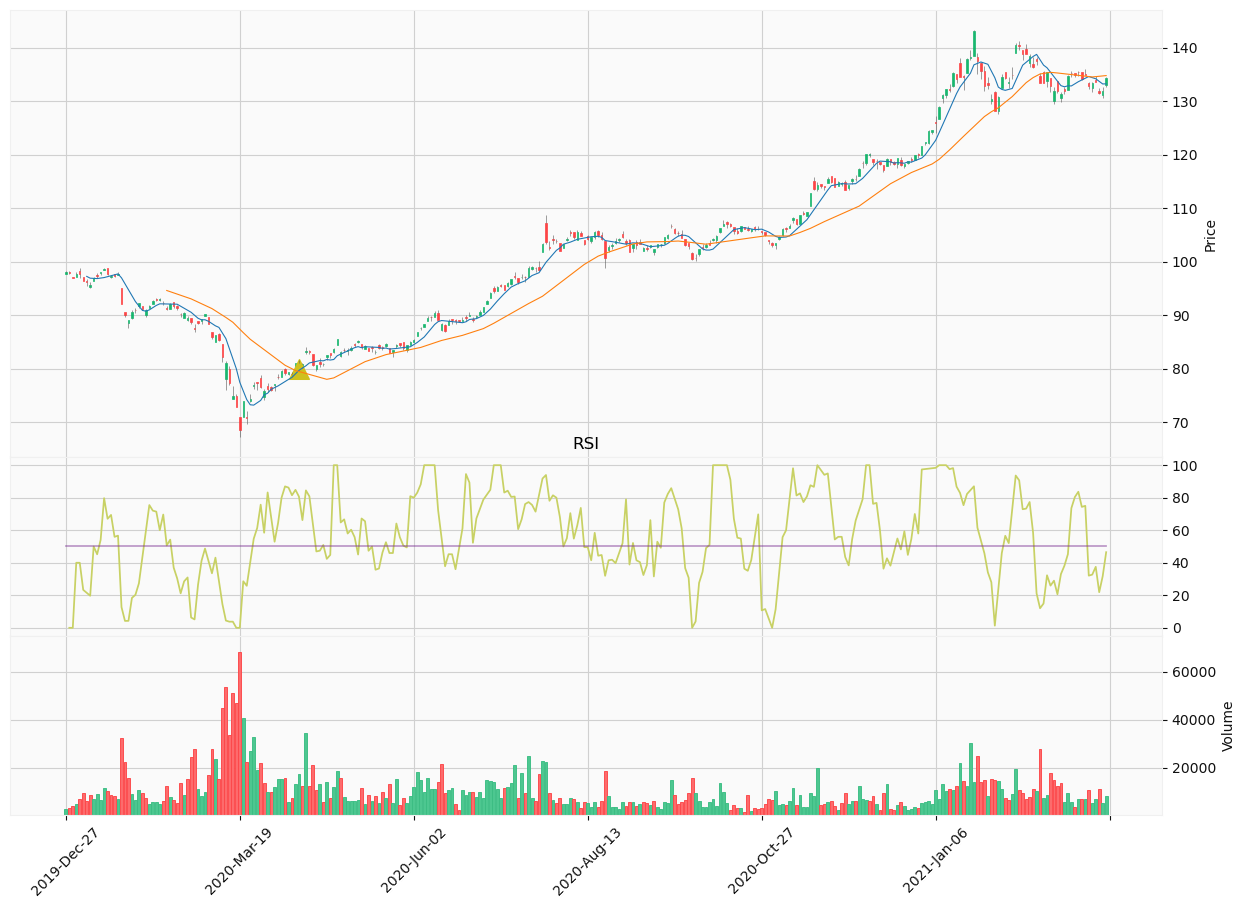

In [22]:
plots = []

# the position in graph
buy, sell = [], []

# Adjust the position to avoid signals block the lines
for index, row in data.iterrows():
    buy.append(row['Close']*0.985 if strategy_3.loc[index]['buy'] else np.nan)
    sell.append(row['Close']*1.01 if strategy_3.loc[index]['sell'] else np.nan)


plots = [ 
    # Add the RSI indicator to plot
    mpf.make_addplot(data['RSI'], panel = 1, color='#c8d164', title='RSI'),
    
    
    # Add middle_line to plot
    mpf.make_addplot(np.full((len(data)), middle_line), panel = 1, color='#7e3696', alpha=0.5),
]

# Add trading point to plot
#    np.isnan(sell) determine the value is nan or not
#    count_nonzero(np.isnan(sell)) counts how many nan we have
#    if nan amount equal the length of array, we don't have sell record
if not np.count_nonzero(np.isnan(sell)) == len(sell):
    plots.append(mpf.make_addplot(sell , type = 'scatter', color = 'red', marker = 'v', markersize = 100))
if not np.count_nonzero(np.isnan(buy)) == len(buy):
    plots.append(mpf.make_addplot(buy , type = 'scatter', color = '#cfc01d', marker = '^', markersize = 200))

mpf.plot( data, 
            type='candle',       # candlestick chart of stock price
            volume=True,         # plots trading volume as well
            volume_panel=2,
            mav = (MOVING_WINDOW_SHORT, MOVING_WINDOW_LONG), 
            figscale=2,          # make graph twice bigger
            style='yahoo',       # color scheme using 'yahoo' style
            addplot = plots,
)    

### 7.4 中線+MA：回溯檢驗

In [23]:
# how many shares we hold, and the money balance
have_shares , balance = 0, 0

# multiple buy and 1 sell as "a trade"
# record trading times and how many trade are making money
make_money, trade_times = 0, 0

# we use geometic average
# this is products of return rate
return_rate = 1
for index, row in data.iterrows():
    
    if(strategy_3.loc[index]['buy'] == 1):
        balance -= row['Close']
        have_shares += 1
        print('buy  | {} | {:>6.2f}'.format( index, row['Close']))
    
    # sell signal or it reach ends
    elif((strategy_3.loc[index]['sell'] == 1 or index == data.index.values[-1])and
    # and we have some shares
          have_shares != 0):
        
        print('sell | {} | {:>6.2f} * {}'.format(index, row['Close'], have_shares))
        
        principal = -balance
        balance += row['Close'] * have_shares
        
        # to calculate accuracy
        trade_times += 1
        if(balance > 0):
            make_money += 1
            
        # plus 1 avoiding get too small
        return_rate *= 1+(balance / principal)
        
        # reset balance & shares
        balance = 0
        have_shares = 0
      

print()
print('cumulative return rate :', (return_rate-1) * 100, '%')
if(trade_times != 0):
    print('accuracy :', make_money/ trade_times * 100, '%')

buy  | 2020-04-15 00:00:00 |  81.20
sell | 2021-03-26 00:00:00 | 134.35 * 1

cumulative return rate : 65.45566502463052 %
accuracy : 100.0 %


---
Other reference：

